<font size="5">Thesis file</font>
<br>

</font>

<font size="4">1. Install necessities</font>
<br>



In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import csv
import imblearn
import numpy as np

import os
import seaborn as sns
from sklearn import metrics
from collections import Counter
from matplotlib import pyplot
from numpy import where
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
import gc
from imblearn.over_sampling import RandomOverSampler
!pip install pandas plotnine
import warnings
warnings.filterwarnings('ignore')
#from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_histogram
from sklearn.model_selection import cross_val_predict
from scipy import stats
from scipy.stats import wilcoxon
from sys import path




[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


<font size="4">2. Load and prepare data </font>
<br>



In [2]:
df = pd.read_csv("ESS10.csv", low_memory = False)

In [3]:
##Only include relevant variables
df_relevant_vars = df[['teamfeel', 'mansupp', 'hincfel', 'trdawrk', 
                       'manhlp', 'mcwrkhom', 'stfmjob']].copy()
df_relevant_vars.stfmjob.count()

18060

df_relevant_vars includes only the vars that I use in this study, it leaves out all other variables assesed in the ESS. 

<font size="4">
    2a. Missing values

In [4]:
##Delete missing values from satisfied with job
values = [55, 66, 77, 88, 99]
df_SF_complete = df_relevant_vars[df_relevant_vars.stfmjob.isin(values) == False]
print('Individuals missing satisfaction score:', df_relevant_vars.stfmjob.count() - df_SF_complete.stfmjob.count(), 
     '\nRemaining = ', df_SF_complete.stfmjob.count()) 

Individuals missing satisfaction score: 8149 
Remaining =  9911


In [5]:
##General missing values 33, 55, 66, 77, 88, 99 set to NaN
for col in['mansupp', 'teamfeel','mcwrkhom']:
    df_SF_complete.loc[df_SF_complete[col] >= 33, col] = np.nan

df_SF_complete only includes the vars that have data for job satisfaction

In [6]:
##General missing values 55, 66, 77, 88, 99 set to NaN
for col in['hincfel', 'trdawrk', 'manhlp']:
    df_SF_complete.loc[df_SF_complete[col] >= 6, col] = np.nan


In [7]:
0.6 * df_SF_complete.stfmjob.count()

5946.599999999999

In [8]:
##Drop columns if more than 60% of data is missing. This is not the case for the vars
drop_cols = []
for col in ['mansupp', 'teamfeel','mcwrkhom','hincfel', 'trdawrk', 'manhlp']:
    if df_SF_complete[col].isna().sum() >= 0.6 * df_SF_complete.stfmjob.count():
        print(col)
        drop_cols.append(col)
        
print(drop_cols)
print(df_SF_complete.head())



[]
   teamfeel  mansupp  hincfel  trdawrk  manhlp  mcwrkhom  stfmjob
1      10.0      NaN      1.0      4.0     NaN      10.0        9
2       6.0      NaN      2.0      4.0     NaN       5.0        5
3      10.0     10.0      3.0      3.0     2.0       NaN        7
4       7.0      4.0      3.0      5.0     2.0       0.0        4
7      10.0      8.0      3.0      3.0     1.0       NaN        6


In [9]:
##count NaN per row
missing = []
for i in range(len(df_SF_complete.index)):
    value = (df_SF_complete.iloc[i].isnull().sum())
    missing.append(value)
df_SF_complete['missing'] = missing
df_SF_complete.head()

,teamfeel,mansupp,hincfel,trdawrk,manhlp,mcwrkhom,stfmjob,missing
1,10.0,NaN,1.0,4.0,NaN,10.0,9,2
2,6.0,NaN,2.0,4.0,NaN,5.0,5,2
3,10.0,10.0,3.0,3.0,2.0,NaN,7,1
4,7.0,4.0,3.0,5.0,2.0,0.0,4,0
7,10.0,8.0,3.0,3.0,1.0,NaN,6,1


In [10]:
##Delete individuals with XX amount of missing values
df_missing_deleted = df_SF_complete[df_SF_complete.missing <= 3].copy()
df_missing_deleted.missing.count()
print('There were:', 9911, 'individuals',
    '\nIndividuals missing too many values:', 9911 - df_missing_deleted.missing.count(),
     '\nRemaing individuals:', df_missing_deleted.missing.count())

There were: 9911 individuals 
Individuals missing too many values: 832 
Remaing individuals: 9079


In [11]:
df_missing_deleted.head()

,teamfeel,mansupp,hincfel,trdawrk,manhlp,mcwrkhom,stfmjob,missing
1,10.0,NaN,1.0,4.0,NaN,10.0,9,2
2,6.0,NaN,2.0,4.0,NaN,5.0,5,2
3,10.0,10.0,3.0,3.0,2.0,NaN,7,1
4,7.0,4.0,3.0,5.0,2.0,0.0,4,0
7,10.0,8.0,3.0,3.0,1.0,NaN,6,1


df_missing_deleted only includes individuals that have enough data on all vars. 
the columns containing too few participants are already deleted here. 

Elke missing value wordt vervangen door mode (Quintero et al., compared the missing values)


In [12]:
#Missing values vervangen met MODE
for col in ['mansupp', 'teamfeel','mcwrkhom','hincfel', 'trdawrk', 'manhlp']:
    df_missing_deleted[col].fillna(df_missing_deleted[col].value_counts().idxmax(), inplace=True)

print(df_missing_deleted.head())
df_final = df_missing_deleted.copy()

##This is also appropriate for income, since income is also made ordinal. 

   teamfeel  mansupp  hincfel  trdawrk  manhlp  mcwrkhom  stfmjob  missing
1      10.0      8.0      1.0      4.0     1.0      10.0        9        2
2       6.0      8.0      2.0      4.0     1.0       5.0        5        2
3      10.0     10.0      3.0      3.0     2.0       0.0        7        1
4       7.0      4.0      3.0      5.0     2.0       0.0        4        0
7      10.0      8.0      3.0      3.0     1.0       0.0        6        1


<font size="4"> 2b Prepare job satisfaction</font>
<br>

In [13]:
##Divide job satisfaction into 4 categories. 
satisfaction = []
for i in df_final.stfmjob:
    if i <=4:
        satisfaction.append(1)
    if i == 5:
        satisfaction.append(2)
    if i == 6 or i == 7:
        satisfaction.append(3)
    if i >= 8 and i <= 10:
        satisfaction.append(4)
df_final['satisfaction'] = satisfaction
df_final.head()

,teamfeel,mansupp,hincfel,trdawrk,manhlp,mcwrkhom,stfmjob,missing,satisfaction
1,10.0,8.0,1.0,4.0,1.0,10.0,9,2,4
2,6.0,8.0,2.0,4.0,1.0,5.0,5,2,2
3,10.0,10.0,3.0,3.0,2.0,0.0,7,1,3
4,7.0,4.0,3.0,5.0,2.0,0.0,4,0,1
7,10.0,8.0,3.0,3.0,1.0,0.0,6,1,3


df_final is final dataframe

In [14]:
data = df_final
data.head()

,teamfeel,mansupp,hincfel,trdawrk,manhlp,mcwrkhom,stfmjob,missing,satisfaction
1,10.0,8.0,1.0,4.0,1.0,10.0,9,2,4
2,6.0,8.0,2.0,4.0,1.0,5.0,5,2,2
3,10.0,10.0,3.0,3.0,2.0,0.0,7,1,3
4,7.0,4.0,3.0,5.0,2.0,0.0,4,0,1
7,10.0,8.0,3.0,3.0,1.0,0.0,6,1,3


<font size="4">
    3. Split train and test

In [15]:
##Split data into train and test
features = ['mansupp', 'teamfeel','mcwrkhom','hincfel', 'trdawrk', 'manhlp']
target = ['satisfaction']
X = data[features]
y = data[target]
test_size = 0.2
X_train, X_test_final, y_train, y_test_final = train_test_split(X, y, test_size = test_size, random_state =0)
#sc = StandardScaler()
data.head()

,teamfeel,mansupp,hincfel,trdawrk,manhlp,mcwrkhom,stfmjob,missing,satisfaction
1,10.0,8.0,1.0,4.0,1.0,10.0,9,2,4
2,6.0,8.0,2.0,4.0,1.0,5.0,5,2,2
3,10.0,10.0,3.0,3.0,2.0,0.0,7,1,3
4,7.0,4.0,3.0,5.0,2.0,0.0,4,0,1
7,10.0,8.0,3.0,3.0,1.0,0.0,6,1,3


In [16]:
print(np.shape(X_test_final))
print(np.shape(y_test_final))
print(np.shape(X_train))
print(np.shape(y_train))

(1816, 6)
(1816, 1)
(7263, 6)
(7263, 1)


<font size="4">
   4.  Oversampling

In [17]:
##Oversampling:
#probeer het ook een keer met undersampling
#kijk of je aan het overfitten bent. (= overal majority voorspellen)
print("Before oversampling and setting seed", Counter(data.satisfaction))
print('Before oversampling, after train test split', Counter(y_train.satisfaction))
print('testdata', Counter(y_test_final.satisfaction))
oversample = RandomOverSampler(sampling_strategy = 'all')
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)
data_oversampled = X_train_oversampled.copy()
data_oversampled['y_train_oversampled'] = y_train_oversampled.copy()
print("After", Counter(data_oversampled.y_train_oversampled))

Before oversampling and setting seed Counter({4: 5147, 3: 2450, 2: 830, 1: 652})
Before oversampling, after train test split Counter({4: 4077, 3: 2002, 2: 668, 1: 516})
testdata Counter({4: 1070, 3: 448, 2: 162, 1: 136})
After Counter({3: 4077, 1: 4077, 4: 4077, 2: 4077})


#Use these when you only want 10% of all oversampled train data
X_10p_train_oversampled = X_train_oversampled.sample(frac = 0.1, random_state = 2)
y_10p_train_oversampled = y_train_oversampled.sample(frac = 0.1, random_state = 2)
traindata_10p_oversample = X_10p_train_oversampled.copy()
traindata_10p_oversample['y_10p_train_oversampled'] = y_10p_train_oversampled.copy()

df = traindata_10p_oversample.copy()

Using the randomstate in the above cell ensures I get the same sample everytime

In [18]:
#use this if you want all oversampled traindata
df = data_oversampled

<font size="4."> 5. Functions ordinal classification</font>
<br>



<font size="4"> 5a. Download functions</font>
<br>



In [19]:
!make

make -e -C classifiers/libsvmRank/python
make[1]: Entering directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/libsvmRank/python'
python setup.py build_ext --inplace && rm -f redsvm.cpp && rm -Rf build
running build_ext
make[1]: Leaving directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/libsvmRank/python'
make -e -C classifiers/svorex
make[1]: Entering directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/svorex'
python setup.py build_ext --inplace && rm -f svorex.cpp && rm -Rf build
running build_ext
make[1]: Leaving directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/svorex'


In [20]:
!python config.py with configurations/single_test.json seed=12345 -l ERROR


###############################
	Running Experiment
###############################

Running tae dataset
--------------------------
Running SVMOP ...
  Running Partition 0
  Running Partition 1
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 2
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 3
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previou


Running balance-scale dataset
--------------------------
Running SVMOP ...
  Running Partition 0
  Running Partition 1
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 2
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 3
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 4
/Users/jolijneikelboom/Library/CloudS


Running contact-lenses dataset
--------------------------
Running SVMOP ...
  Running Partition 0
  Running Partition 1
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 2
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 3
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 4
/Users/jolijneikelboom/Library/Cloud

In [21]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [22]:
X_train_oversampled.isnull().values.any()

False

<font size="4">5b. Apply functions</font>
<br>



<font size="4">
    5.b.1. CSV1V1 
<font size="3">    
    Why use neg_mean_absolute_error: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Add here new parameters for C to addd + make sure it is OVO instead of OVR
https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

In [23]:
param_grid = {'estimator__C': [0.1, 1, 10], 'estimator__gamma': [10, 1,0.1]}
model = SVC(decision_function_shape = 'ovo')
ovo = OneVsOneClassifier(model)
ovo_gscv = GridSearchCV(ovo, param_grid, scoring = 'neg_mean_absolute_error', return_train_score = True, cv = 4, verbose = 3)
ovo_gscv.fit(X_train_oversampled, y_train_oversampled) #je fit hem op de oversamplede data

print(ovo_gscv.best_params_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END ..........estimator__C=0.1, estimator__gamma=10; total time= 1.2min
[CV 2/4] END ..........estimator__C=0.1, estimator__gamma=10; total time=  57.3s
[CV 3/4] END ..........estimator__C=0.1, estimator__gamma=10; total time=  51.6s
[CV 4/4] END ..........estimator__C=0.1, estimator__gamma=10; total time=  48.3s
[CV 1/4] END ...........estimator__C=0.1, estimator__gamma=1; total time=  41.2s
[CV 2/4] END ...........estimator__C=0.1, estimator__gamma=1; total time=  43.1s
[CV 3/4] END ...........estimator__C=0.1, estimator__gamma=1; total time=  43.3s
[CV 4/4] END ...........estimator__C=0.1, estimator__gamma=1; total time=  51.0s
[CV 1/4] END .........estimator__C=0.1, estimator__gamma=0.1; total time=  32.0s
[CV 2/4] END .........estimator__C=0.1, estimator__gamma=0.1; total time=  31.3s
[CV 3/4] END .........estimator__C=0.1, estimator__gamma=0.1; total time=  40.6s
[CV 4/4] END .........estimator__C=0.1, estimator

In [25]:
#ovo_best = ovo(param_grid = {'estimator__C': 10, 'estimator__gamma': 0.01,'estimator__kernel': 'rbf'}
ovo_gscv_predictions = ovo_gscv.predict(X_test_final) 
ovo_gscv_df = X_test_final.copy()
ovo_gscv_df.insert(6, 'Actual', y_test_final, True)
ovo_gscv_df.insert(6, 'Predicted', ovo_gscv_predictions, True)

list_true_scores = list(ovo_gscv_df['Actual'])
list_ovo_gscv_predicted = list(ovo_gscv_df['Predicted'])

ovo_gscv_df.head()

,mansupp,teamfeel,mcwrkhom,hincfel,trdawrk,manhlp,Predicted,Actual
4998,5.0,10.0,5.0,1.0,3.0,1.0,4,3
17232,5.0,10.0,5.0,2.0,1.0,2.0,4,4
4911,10.0,8.0,5.0,2.0,2.0,2.0,4,4
16185,8.0,10.0,0.0,1.0,4.0,1.0,4,4
17455,2.0,5.0,0.0,3.0,4.0,3.0,4,1


print(ovo_gscv_df.Actual)

In [26]:
print(y_train.value_counts())
print(y_train_oversampled.value_counts())
print(y_test_final.value_counts())

satisfaction
4               4077
3               2002
2                668
1                516
dtype: int64
satisfaction
1               4077
2               4077
3               4077
4               4077
dtype: int64
satisfaction
4               1070
3                448
2                162
1                136
dtype: int64


In [27]:
ovo_gscv_true = ovo_gscv_df.Actual
ovo_gscv_predicted = ovo_gscv_df.Predicted

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

print('Mae SCV1V1 after gridsearch', mae(ovo_gscv_true, ovo_gscv_predicted))
print('The best estimators:', ovo_gscv.best_estimator_)
mae_ovo_gscv = mae(ovo_gscv_true, ovo_gscv_predicted)

Mae SCV1V1 after gridsearch 0.8045154185022027
The best estimators: OneVsOneClassifier(estimator=SVC(C=1, decision_function_shape='ovo', gamma=10))


[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


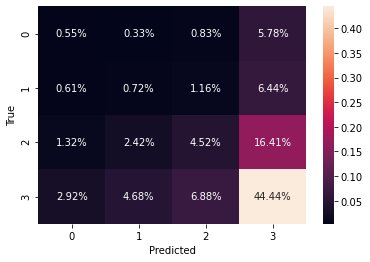

In [36]:
##CM with percentages
ovo_cf_matrix = confusion_matrix(ovo_gscv_true, ovo_gscv_predicted)
##CM with Percentages
ovo_ax = sns.heatmap(ovo_cf_matrix/np.sum(ovo_cf_matrix), annot=True, 
            fmt='.2%')
print(ovo_ax.set(xlabel='Predicted', ylabel='True'))

In [29]:
true_scores = ovo_gscv_df.Actual.copy()
print('mae is', mae(true_scores, ovo_gscv_predictions))
print('mze is', zero_one_loss(true_scores, ovo_gscv_predictions))

0.8045154185022027


0.4977973568281938

In [ ]:
true_scores = ovo_gscv_df.Actual.copy()
print(len(true_scores))

Find Optimal C by grid search 
https://datascience.stackexchange.com/questions/41680/how-to-implement-gridsearchcv-for-onevsrestclassifier-of-logisticregression-clas

<font size="4">
    5.b.2. SVMOP

https://towardsdatascience.com/grid-search-in-python-from-scratch-hyperparameter-tuning-3cca8443727b

In [31]:
path.append('classifiers')
svmopModule = __import__("OrdinalDecomposition")
svmop= svmopModule.OrdinalDecomposition

In [32]:
parameter_list_C = [0.1, 1, 10]
parameter_list_Gamma = [0.1, 1, 10]

kf = KFold(n_splits=4, random_state=None, shuffle=False)

#kf.split split en geeft indexes van X en y voor elke split.  
#loc gebruikt namen, iloc gebruikt index



In [33]:
for C in parameter_list_C:
    for G in parameter_list_Gamma: #Hier gaat die dus voor de value van C, over elk van G. 
        print(f'C is nu: {C}, G is nu {G}')
        svmop_gscv = svmop(dtype = 'ordered_partitions', 
                              decision_method = 'frank_hall', 
                               base_classifier = 'sklearn.svm.SVC', 
                               parameters={'C': C,
                                           'gamma':G, 
                                           'probability':True})
        mae_fold = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,], y.iloc[test_index,]
            svmop_gscv_fit = svmop_gscv.fit(X_train, y_train)
            svmop_gscv_predictions = svmop_gscv.predict(X_test)
            real_scores_svmop = list(y_test['satisfaction'])
            mae_in_between = mae(real_scores_svmop, svmop_gscv_predictions)
            mae_fold += mae_in_between
            print(mae_in_between)
        print('belonging mae is:', mae_fold /4)
    

C is nu: 0.1, G is nu 0.1
0.6211453744493393
0.43348017621145374
0.5127753303964758
0.5337152930806522
belonging mae is: 0.5252790435344803
C is nu: 0.1, G is nu 1
0.6977973568281939
0.4726872246696035
0.56784140969163
0.5830762450418686
belonging mae is: 0.580350559057824
C is nu: 0.1, G is nu 10
0.7991189427312775
0.5044052863436124
0.6409691629955947
0.6906126046716615
belonging mae is: 0.6587764991855365
C is nu: 1, G is nu 0.1
0.620704845814978
0.4365638766519824
0.5114537444933921
0.5376817981489643
belonging mae is: 0.5266010662773292
C is nu: 1, G is nu 1
0.7101321585903083
0.4894273127753304
0.5713656387665198
0.630674305861613
belonging mae is: 0.6003998539984429
C is nu: 1, G is nu 10
0.7784140969162996
0.5149779735682819
0.6418502202643172
0.6919347730277655
belonging mae is: 0.6567942659441661
C is nu: 10, G is nu 0.1
0.6453744493392071
0.44933920704845814
0.5198237885462555
0.5632437197003085
belonging mae is: 0.5444452911585573
C is nu: 10, G is nu 1
0.7577092511013216
0

In [34]:
print(y_test_final.value_counts())
print(y_train_oversampled.value_counts())

satisfaction
4               1070
3                448
2                162
1                136
dtype: int64
satisfaction
1               4077
2               4077
3               4077
4               4077
dtype: int64


In [35]:
svmop_gscv_df = X_test.copy()
svmop_gscv_df.insert(5, 'Actual', y_test, True)
svmop_gscv_df.insert(5, 'Predicted', svmop_gscv_predictions, True)

svmop_gscv_true = svmop_gscv_df.Actual
svmop_gscv_predicted = svmop_gscv_df.Predicted

mae_svmop_gscv = mae(svmop_gscv_true, svmop_gscv_predicted)

In [37]:
svmop_best = svmop(dtype = 'ordered_partitions', 
                               decision_method = 'frank_hall', 
                               base_classifier = 'sklearn.svm.SVC', 
                               parameters={'C': 0.1,
                                           'gamma': 0.1, 
                                           'probability':True})
svmop_best.fit(X_train_oversampled, y_train_oversampled)
svmop_best_predictions = svmop_best.predict(X_test_final)



[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


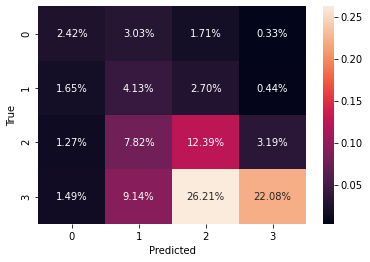

In [41]:
svmop_cf_matrix = confusion_matrix(true_scores, svmop_best_predictions)

svmop_ax = sns.heatmap(svmop_cf_matrix/np.sum(svmop_cf_matrix), annot=True, 
            fmt='.2%')
print(svmop_ax.set(xlabel='Predicted', ylabel='True'))

In [39]:
print(mae(true_scores, svmop_best_predictions))
print(zero_one_loss(true_scores, svmop_best_predictions))

0.7516519823788547
0.5897577092511013


<font size="4">
    5.b.3. SVOREX

In [43]:
path.append('classifiers')
svorexModule = __import__("SVOREX")
svorex= svorexModule.SVOREX

In [42]:
valuesC = [0.01, 0.1, 1, 10]

##Bij deze methode pakt die de hoogste MAE vanuit een fold ipv ze te middelen. 
svorex_gscv = GridSearchCV(estimator=svorex(), 
                           scoring = 'neg_mean_absolute_error', 
                           param_grid={'c': valuesC, 'k': valuesK}, 
                           cv=4, n_jobs=-1)

#Se entrena el modelo SVOREX con los datos de entrenamiento
svorex_gscv_fit = svorex_gscv.fit(X_10p_train_oversampled, y_10p_train_oversampled)

#Se predicen las etiquetas de test
svorex_gscv_predictions = svorex_gscv.predict(X_test)

svorex_gscv_df = X_test.copy()
svorex_gscv_df.insert(37, 'Actual', y_test, True)
svorex_gscv_df.insert(37, 'Predicted', svorex_gscv_predictions, True)

svorex_gscv_df.head()

svorex_gscv_true = svorex_gscv_df.Actual
svorex_gscv_predicted = svorex_gscv_df.Predicted

list_svorex_gscv_true = list(svorex_gscv_df.Actual)
list_svorex_gscv_predicted = list(svorex_gscv_df.Predicted)

print('Mae svorex after gridsearch', mae(svorex_gscv_true, svorex_gscv_predicted))
print("The best estimators:", svorex_gscv.best_estimator_)

##CM with counts 
svorex_gscv_cf_matrix = confusion_matrix(svorex_gscv_predicted, svorex_gscv_true)
##CM with Percentages
svorex_ax = sns.heatmap(svorex_gscv_cf_matrix/np.sum(svorex_gscv_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
svorex_ax.set_title('CM svorex after gridsearch, MAE: 0.18')
print(svorex_ax.set(xlabel='True', ylabel='Predicted'))

In [45]:
#SVOREX with selfmade gridsearch CV to check if it gives the same result --> does not, bij deze middelt die niet
for C in valuesC:
    for K in valuesK: #Hier gaat die dus voor de value van C, over elk van K. 
        print(f'C is nu: {C}')
        SVOREX_gscv = svorex(c = C)
        mae_fold = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,], y.iloc[test_index,]
            SVOREX_gscv_fit = SVOREX_gscv.fit(X_train, y_train)
            SVOREX_gscv_predictions = SVOREX_gscv.predict(X_test)
            real_scores_svorex = list(y_test['satisfaction'])
            mae_fold += mae(y_test, SVOREX_gscv_predictions)
            print(mae(y_test, SVOREX_gscv_predictions))
        print('belonging mae is:', mae_fold /4 )
        

SVOREX_best_fit = SVOREX_best.fit(X_train_oversampled, y_train_oversampled)

C is nu: 0.1, K is nu 0.1
0.8196867783190048
0.513043140755691
0.6834889091579499
0.7227822602183491
belonging mae is: 0.6847502721127487
C is nu: 0.1, K is nu 1
0.8185022026431719
0.5004405286343613
0.6497797356828194
0.7038342882327017
belonging mae is: 0.6681391887982635
C is nu: 0.1, K is nu 10
0.8185022026431719
0.5004405286343613
0.6497797356828194
0.7038342882327017
belonging mae is: 0.6681391887982635
C is nu: 1, K is nu 0.1
0.8813526363795144
0.5506534184633896
0.7334704729375692
0.7695977418832907
belonging mae is: 0.7337685674159409
C is nu: 1, K is nu 1
0.8257427856158668
0.5481068912651128
0.6761377088629704
0.736336088320147
belonging mae is: 0.6965808685160242
C is nu: 1, K is nu 10
0.8196514584020649
0.5063614663587495
0.6565933746045916
0.7302807631399585
belonging mae is: 0.6782217656263411
C is nu: 10, K is nu 0.1
0.9166589687360516
0.5881084437889343
0.763178016262687
0.7945064458378113
belonging mae is: 0.7656129686563711
C is nu: 10, K is nu 1
0.8414384133206544
0

NameError: name 'SVOREX_best' is not defined

In [46]:
SVOREX_best = svorex(c = 1)
SVOREX_best.fit(X_train_oversampled, y_train_oversampled)
SVOREX_best_predictions = SVOREX_best.predict(X_test_final)

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


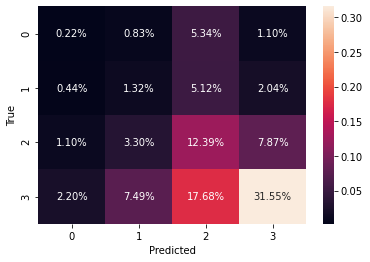

In [49]:
SVOREX_cf_matrix = confusion_matrix(y_test_final, SVOREX_best_predictions)
##CM with Percentages
svorex_new = sns.heatmap(SVOREX_cf_matrix/np.sum(SVOREX_cf_matrix), annot=True, 
            fmt='.2%')
print(svorex_new.set(xlabel='Predicted', ylabel='True'))



In [48]:
print(mae(y_test_final, SVOREX_best_predictions))
print(zero_one_loss(y_test_final, SVOREX_best_predictions))

0.8995298763802907
0.5451541850220265


<font size="4">
    5.b.4. REDSVM

In [50]:
path.append('classifiers')
redsvmModule = __import__("REDSVM")
redsvm = redsvmModule.REDSVM
valuesG = [0.1, 1, 10]
valuesc = [0.1, 1, 10]
kf = KFold(n_splits=4, random_state=None, shuffle=False)

#Se prepara la selección de parámetros
redsvm_gscv = GridSearchCV(estimator=redsvm(), scoring = 'neg_mean_absolute_error', param_grid={'c': valuesC, 'g': valuesG}, cv=4, n_jobs=-1)

#Se entrena el modelo REDSVM con los datos de entrenamiento
redsvm_gscv_fit = redsvm_gscv.fit(X_10p_train_oversampled, y_10p_train_oversampled)

#Se predicen las etiquetas de test
redsvm_gscv_predictions = redsvm_gscv.predict(X_test)


redsvm_gscv_df = X_test.copy()
redsvm_gscv_df.insert(37, 'Actual', y_test, True)
redsvm_gscv_df.insert(37, 'Predicted', redsvm_gscv_predictions, True)

redsvm_gscv_df.head()

redsvm_gscv_true = redsvm_gscv_df.Actual
redsvm_gscv_predicted = redsvm_gscv_df.Predicted
list_redsvm_gscv_true = list(redsvm_gscv_df.Actual)
list_redsvm_gscv_predicted = list(redsvm_gscv_df.Predicted)


#Resultados
mae_redsvm_gscv = mae(redsvm_gscv_true, redsvm_gscv_predicted)
print("Resultados obtenidos")
print("MAE is", mae_redsvm_gscv)
print("The best estimators:", redsvm_gscv.best_estimator_)


##CM with counts 
redsvm_gscv_cf_matrix = confusion_matrix(redsvm_gscv_predicted, redsvm_gscv_true)
##CM with Percentages
redsvm_ax = sns.heatmap(redsvm_gscv_cf_matrix/np.sum(redsvm_gscv_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
redsvm_ax.set_title('CM redsvm')
print(redsvm_ax.set(xlabel='True', ylabel='Predicted'))

In [51]:
##make REDSVM gridsearch by yourself.
for C in valuesc:
    for G in valuesG: #Hier gaat die dus voor de value van C, over elk van G. 
        print(f'C is nu: {C}, g is nu {G}')
        REDSVM_gscv = redsvm(c = C, g = G)
        mae_fold = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,], y.iloc[test_index,]
            REDSVM_gscv_fit = REDSVM_gscv.fit(X_train, y_train)
            REDSVM_gscv_predictions = REDSVM_gscv.predict(X_test)
            real_scores_redsvm = list(y_test['satisfaction']) 
            mae_fold += mae(y_test, REDSVM_gscv_predictions)
            print(mae(y_test, REDSVM_gscv_predictions))
        print('belonging mae is:', mae_fold /4 )


C is nu: 0.1, g is nu 0.1
0.8021770265287508
0.6257963476877099
0.7316714859593627
0.7672259190837628
belonging mae is: 0.7317176948148965
C is nu: 0.1, g is nu 1
0.8183880921422888
0.6460796832851404
0.6601273069533661
0.706494163870793
belonging mae is: 0.7077723115628971
C is nu: 0.1, g is nu 10
0.8185022026431719
0.5008503949232471
0.6497797356828194
0.7038342882327017
belonging mae is: 0.668241655370485
C is nu: 1, g is nu 0.1
0.8259721710104989
0.6401820334180752
0.7484585379106911
0.7853099267902931
belonging mae is: 0.7499806672823895
C is nu: 1, g is nu 1
0.8212711288788838
0.6459403442721574
0.7475367268916533
0.7795288636519467
belonging mae is: 0.7485692659236604
C is nu: 1, g is nu 10
0.8291987036426091
0.6878751770847484
0.706520600050457
0.7412595969863031
belonging mae is: 0.7412135194410294
C is nu: 10, g is nu 0.1
0.8584203070115857
0.659416251043102
0.7722133167730793
0.8056402804698427
belonging mae is: 0.7739225388244024
C is nu: 10, g is nu 1
0.8509581012633662
0.

In [53]:
REDSVM_best = redsvm(c = 0.1, g =10)
REDSVM_best_fit = REDSVM_best.fit(X_train_oversampled, y_train_oversampled)
REDSVM_best_predictions = REDSVM_best.predict(X_test_final)

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


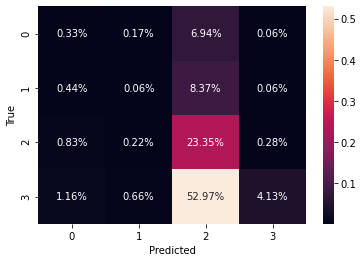

In [54]:
REDSVM_cf_matrix = confusion_matrix(y_test_final, REDSVM_best_predictions)
##CM with Percentages
REDSVM_ax = sns.heatmap(REDSVM_cf_matrix/np.sum(REDSVM_cf_matrix), annot=True, 
            fmt='.2%')

print(REDSVM_ax.set(xlabel='Predicted', ylabel='True'))

In [55]:
print(mae(y_test_final, REDSVM_best_predictions))
print(zero_one_loss(y_test_final, REDSVM_best_predictions))

0.8694424498825903
0.7213656387665198


<font size="4">
5.c Comparison of models

How to apply wilcoxon test:
1.  You need a list which values represent the differences between two groups.
2. In my case, that list should thus compare the error of one model with the error of another model, for every instance. HOW:
    a. make a column that shows error for every model. (example: error_ovo = abs(ovo_predicted - true)
    b. make a list that compares two of those columns. (example: differences = error_ovo - error_svmop).
    c. Now you have the list that compares the errors, as required by step 2. 
3. This list can be put into the wilcoxon test. The wilcoxon takes the list of differences and produces a statistic and p.value.

For example on other dataset see link.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

In [ ]:
print(mae(y_test_final, ovo_gscv_predictions))
print(mae(true_scores, svmop_best_predictions))
print(mae(true_scores, SVOREX_best_predictions))
print(mae(true_scores, REDSVM_best_predictions))

In [56]:
error_ovo = abs(ovo_gscv_predictions - list_true_scores)
error_svmop = abs(svmop_best_predictions - list_true_scores)
error_svorex = abs(np.array(SVOREX_best_predictions) - np.array(list_true_scores))
error_redsvm = abs(np.array(REDSVM_best_predictions) - np.array(list_true_scores))

differences_error_ovo_svmop = list(error_ovo - error_svmop)
differences_error_ovo_svorex = list(error_ovo - error_svorex)
differences_error_ovo_redsvm = list(error_ovo - error_redsvm)
differences_error_svmop_svorex = list(error_svmop - error_svorex)
differences_error_svmop_redsvm = list(error_svmop - error_redsvm)
differences_error_svorex_redsvm = list(error_svorex - error_redsvm)

true_list = list(true_scores)


In [65]:
test_ovo_svmop = wilcoxon(differences_error_ovo_svmop)
print('ovo compared to svmop results: statistic is:', test_ovo_svmop.statistic, 
      'p is', test_ovo_svmop.pvalue)

test_ovo_svorex = wilcoxon(differences_error_ovo_svorex)
print('ovo compared to svorex results: statistic is:', test_ovo_svorex.statistic, 
      'p is', test_ovo_svorex.pvalue)

test_ovo_redsvm = wilcoxon(differences_error_ovo_redsvm)
print('ovo compared to redsvm results: statistic is:', test_ovo_redsvm.statistic, 
      'p is', test_ovo_redsvm.pvalue)

test_svmop_svorex = wilcoxon(differences_error_svmop_svorex)
print('svmop compared to svorex results: statistic is:', test_svmop_svorex.statistic, 
      'p is', test_svmop_svorex.pvalue)

test_svmop_redsvm = wilcoxon(differences_error_svmop_redsvm)
print('svmop compared to redsvm results: statistic is:', test_svmop_redsvm.statistic, 
      'p is', test_svmop_redsvm.pvalue)

test_svorex_redsvm = wilcoxon(differences_error_svorex_redsvm)
print('svorex compared to redsvm results: statistic is:', test_svorex_redsvm.statistic, 
      'p is', test_svorex_redsvm.pvalue)



ovo compared to svmop results: statistic is: 273583.0 p is 0.05381154738964258
ovo compared to svorex results: statistic is: 157589.0 p is 0.046877591955884944
ovo compared to redsvm results: statistic is: 500879.0 p is 0.23237246322509597
svmop compared to svorex results: statistic is: 246941.0 p is 0.3312808173695747
svmop compared to redsvm results: statistic is: 195526.5 p is 7.846907473487039e-05
svorex compared to redsvm results: statistic is: 199998.5 p is 0.0005523293346104324
